In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import json

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans

# Load the processed data

In [3]:
df = pd.read_csv('./data/processed/manhattan_04-20-2022.csv')
df.drop(columns={'cluster_id', 'cluster_id_encoded'},inplace=True)  # Perform on the train set and map to the test set
df['price/sqft'] = df.rent/df.sqft
df = df[df.rent<10000]
df.head()

,rent,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,latitude,longitude,dishwasher,dist_wall_street,dist_waterfront,pets_allowed,beds_times_baths,price/sqft
0,2290.0,500.0,0,0,0,1,0,0,0,0,0,40.74761,-73.97421,0,3.336871,0.004532,1,1.0,4.580000
1,2759.0,725.0,0,0,0,0,0,0,0,1,0,40.82500,-73.94862,0,8.718798,0.006425,1,3.0,3.805517
2,4995.0,1000.0,0,0,0,1,0,0,0,0,0,40.75898,-73.96183,0,4.352061,0.002771,1,3.0,4.995000
3,5550.0,983.0,1,1,0,1,0,0,0,1,1,40.79445,-73.96973,1,6.354176,0.007658,1,4.0,5.645982
4,5700.0,983.0,1,1,0,1,0,0,0,1,1,40.79445,-73.96973,1,6.354176,0.007658,1,4.0,5.798576


In [4]:
# Convert rent and sqft to log scale
df.rent=np.log(df.rent)
df.sqft=np.log(df.sqft)

In [5]:
X = df.drop(['rent'], axis = 1)
y = df['rent']

In [6]:
# split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size = 0.2, random_state = 100)

# Cluster and Target Encodoe on train set

In [7]:
cluster_df = X_train.groupby(['latitude', 'longitude'], as_index=False)['price/sqft'].mean()
cluster_df.head()

,latitude,longitude,price/sqft
0,40.70461,-74.00890,6.310887
1,40.70464,-74.00755,6.526699
2,40.70520,-74.01613,5.125959
3,40.70564,-74.00878,6.682264
4,40.70578,-74.00724,5.913889


In [8]:
def clusters(clusters:int):
    # Find the optimal number of clusters to use
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    
    kmeans = KMeans(n_clusters=clusters, **kmeans_kwargs)
    kmeans.fit(lat_long, sample_weight=weights)
    return kmeans

In [9]:
# Assign clusters to the training set
kmeans = clusters(20)
X_train['cluster_id'] = kmeans.predict(X_train[['latitude','longitude']])
X_train['cluster_id_encoded']=X_train.cluster_id.map(X_train.groupby('cluster_id')['price/sqft'].mean())
X_train.head()

,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,latitude,longitude,dishwasher,dist_wall_street,dist_waterfront,pets_allowed,beds_times_baths,price/sqft,cluster_id,cluster_id_encoded
398,6.214608,0,0,1,0,0,0,0,0,0,40.76413,-73.99104,1,4.023009,0.006715,0,1.0,5.990000,10,6.143595
159,6.214608,1,0,0,1,0,0,0,1,0,40.74635,-73.97603,0,3.211371,0.005305,1,0.0,5.850000,4,6.166254
41,6.165418,0,1,1,1,1,0,1,1,0,40.80459,-73.93608,1,7.734174,0.003861,1,0.0,6.092437,6,5.474281
369,6.396930,1,0,0,1,0,1,0,1,0,40.71011,-74.00774,1,0.207511,0.006169,1,2.0,6.250000,14,6.089255
277,6.586172,1,1,1,1,0,0,0,1,0,40.76916,-73.95996,1,4.991980,0.008777,1,2.0,5.241379,12,5.091535


In [10]:
# Visualize the clusters
fig = px.scatter_mapbox(X_train, lat="latitude", lon="longitude", color="cluster_id", mapbox_style="carto-positron", zoom=11.3)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [11]:
# Get dictionary of clusters and their target encoded value
encoded_clusters = X_train.groupby('cluster_id')['cluster_id_encoded'].unique().astype(float).to_dict()

In [12]:
# Add the clusters and the encoded values to the test set
X_test['cluster_id'] = kmeans.predict(X_test[['latitude','longitude']])
X_test.loc[:,'cluster_id_encoded']=X_test.cluster_id.map(encoded_clusters)
X_test.head()


,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,latitude,longitude,dishwasher,dist_wall_street,dist_waterfront,pets_allowed,beds_times_baths,price/sqft,cluster_id,cluster_id_encoded
293,6.272877,0,0,0,1,0,0,0,1,0,40.76897,-73.96805,0,4.770902,0.014142,1,0.0,5.000000,17,5.795382
514,6.309918,0,0,1,0,0,0,0,1,0,40.72006,-73.98335,1,1.642449,0.009694,1,1.0,5.809091,5,7.260113
212,6.646391,1,0,0,0,0,1,1,1,1,40.74744,-73.97139,0,3.412911,0.002405,1,1.0,8.149351,8,5.696529
102,7.003065,1,0,0,1,1,1,1,0,0,40.76597,-73.98234,0,4.279154,0.013435,0,4.0,6.100000,0,6.383142
1042,6.802395,0,0,0,0,0,0,0,0,0,40.75736,-73.96812,1,4.074561,0.006324,0,9.0,5.438889,17,5.795382


# Prepare the data

In [13]:
# Drop the unecessary columns
cols_drop = {'latitude', 'longitude', 'price/sqft', 'cluster_id'}
X_train.drop(columns={'latitude', 'longitude', 'price/sqft', 'cluster_id'}, inplace=True)
X_test.drop(columns={'latitude', 'longitude', 'price/sqft', 'cluster_id'}, inplace=True)

# 1. Base Model
Construct a linear regression model that only considers rent, number of bedrooms, and distance to the waterfront as the features. The result from this model will be our base model to compare against every other model that is built. 

In [14]:
# Fit the model 
def regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(model.score(X_train, y_train)*100, 2))
    print('R squared test set', round(model.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return model
    
X_base_train = np.array(X_train[['sqft', 'beds_times_baths', 'dist_waterfront']])
X_base_test = np.array(X_test[['sqft', 'beds_times_baths', 'dist_waterfront']])

In [15]:
model = regression(X_base_train, y_train, X_base_test, y_test)

R squared training set 47.19
R squared test set 52.73
RMSE training set 1186.95
MAE training set 893.39
RMSE test set 1230.85
MAE test set 950.46


# 2. Linear Regression

In [16]:
model = regression(X_train, y_train, X_test, y_test)

R squared training set 77.01
R squared test set 76.6
RMSE training set 804.75
MAE training set 572.47
RMSE test set 884.44
MAE test set 633.53


# 2a. Lasso Regression

In [17]:
def lasso_regression(X_train, y_train, X_test, y_test):
    lasso = Lasso(alpha=0.0001)
    lasso.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(lasso.score(X_train, y_train)*100, 2))
    print('R squared test set', round(lasso.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = lasso.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = lasso.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return lasso

In [18]:
lasso = lasso_regression(X_train, y_train, X_test, y_test)

R squared training set 76.83
R squared test set 76.6
RMSE training set 808.4
MAE training set 573.56
RMSE test set 888.51
MAE test set 634.61


# 2b. Ridge Regression

In [19]:
def ridge_regression(X_train, y_train, X_test, y_test):
    ridge = Ridge(alpha=0.0001)
    ridge.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(ridge.score(X_train, y_train)*100, 2))
    print('R squared test set', round(ridge.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = ridge.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = ridge.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return ridge

In [20]:
ridge = ridge_regression(X_train, y_train, X_test, y_test)

R squared training set 77.01
R squared test set 76.6
RMSE training set 804.76
MAE training set 572.47
RMSE test set 884.44
MAE test set 633.5


# 3. XGBoost

In [21]:
def xgboost(X_train, y_train, X_test, y_test):
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)

    # Training data
    pred_train = xgb.predict(X_train)
    r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))

    # Test data
    pred_test = xgb.predict(X_test)
    r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    
    # Print results
    print('R squared training set', round(r2_train,2))
    print('R squared test set', round(r2_test,2))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return xgb

xgb = xgboost(X_train, y_train, X_test, y_test)

R squared training set 0.99
R squared test set 0.86
RMSE training set 164.73
MAE training set 87.7
RMSE test set 668.31
MAE test set 432.86


# 4. Random Forest

In [22]:
def randomForest(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Training data
    pred_train = rf.predict(X_train)
    r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))

    # Test data
    pred_test = rf.predict(X_test)
    r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    
    # Print results
    print('R squared training set', round(r2_train,2))
    print('R squared test set', round(r2_test,2))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return rf

rf = randomForest(X_train, y_train, X_test, y_test)

R squared training set 0.97
R squared test set 0.87
RMSE training set 271.51
MAE training set 176.54
RMSE test set 633.72
MAE test set 417.02


# 5. Comparing the models

In [23]:
results = {'Actual': np.exp(y_test),
           'LinReg': np.exp(model.predict(X_test)),
           'Lasso': np.exp(lasso.predict(X_test)),
           'XGB': np.exp(xgb.predict(X_test)),
           'RF': np.exp(rf.predict(X_test))}

results_df = pd.DataFrame.from_dict(results)
results_df.head(10)

,Actual,LinReg,Lasso,XGB,RF
293,2650.0,2835.007662,2735.778600,2617.238281,2496.708784
514,3195.0,3760.214893,3747.586942,3092.327393,3032.133979
212,6275.0,4515.595536,4445.793873,4830.665039,4746.075517
102,6710.0,6542.561539,6182.394150,6652.257324,6598.118807
1042,4895.0,5115.890366,5144.575865,5023.207031,5272.236746
874,3383.0,3664.483627,3648.785988,3431.323486,3496.828458
639,3105.0,3501.355725,3537.028568,3222.618652,3169.245685
826,1975.0,2670.240672,2715.171329,2199.062744,2446.148214
1128,4762.0,4248.621095,4258.120312,4390.454102,4518.441097
141,2975.0,2015.600539,1972.952597,1931.833008,1946.568377


<Figure size 720x1080 with 0 Axes>

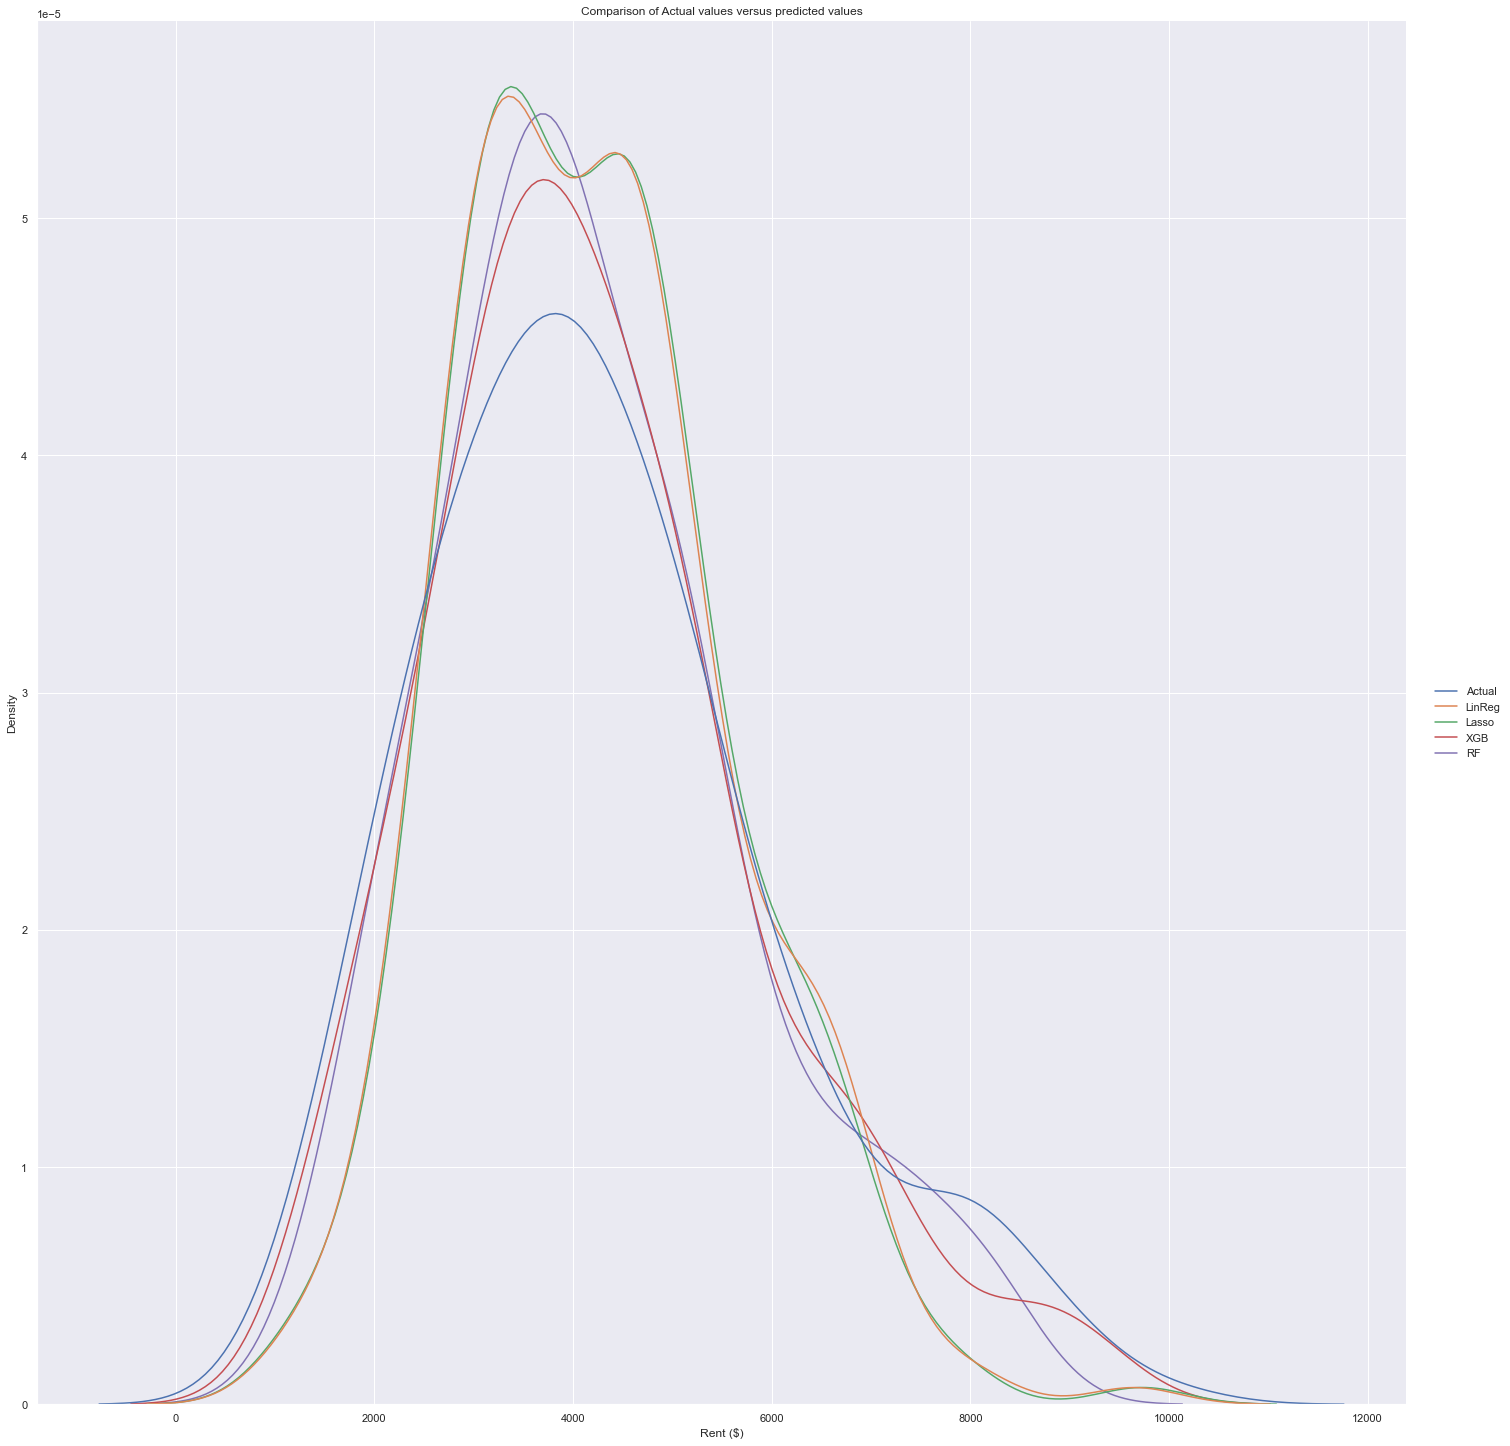

In [24]:
# Plot the results on a distribution 
plt.figure(figsize = (10,15))

ax = sns.displot(data = results_df, kind='kde', height = 20)
plt.title('Comparison of Actual values versus predicted values')
plt.xlabel('Rent ($)')
plt.show()

Both the XGB and Rand Forest models appear to be very similar. This was too be expected as this problem is well suited to tree based models. XGBoost has a slight edge in overall peformance so we will look at tuning the hyperparameters next. Focus will need to be placed on generalizing the model performance as it's definitely overfitting the data currently.

### Actual versus Predicted

/var/folders/1v/2xtr296s1rz_4kd_c4kx7qh00000gn/T/ipykernel_21930/4062441232.py:8: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.



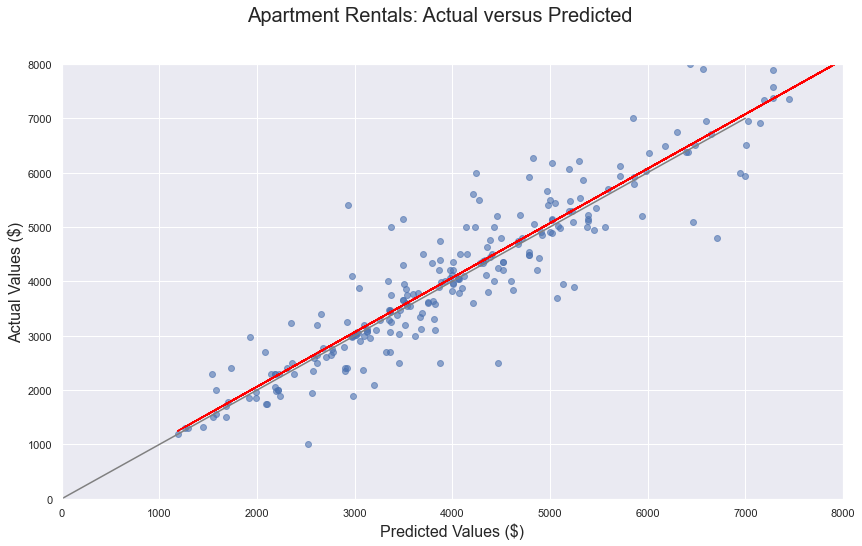

In [25]:
import matplotlib.pylab as plb 

plt.figure(figsize=(14, 8))
plt.scatter(np.exp(xgb.predict(X_test)), np.exp(y_test), alpha=.6) 

z = np.polyfit(np.exp(xgb.predict(X_test)), np.exp(y_test), 1)
p = np.poly1d(z)
plb.plot(np.exp(xgb.predict(X_test)), p(np.exp(xgb.predict(X_test))), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 8000)
plt.ylim(0, 8000)

plt.suptitle('Apartment Rentals: Actual versus Predicted', fontsize=20, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial');

Text(0, 0.5, 'Residuals ($)')

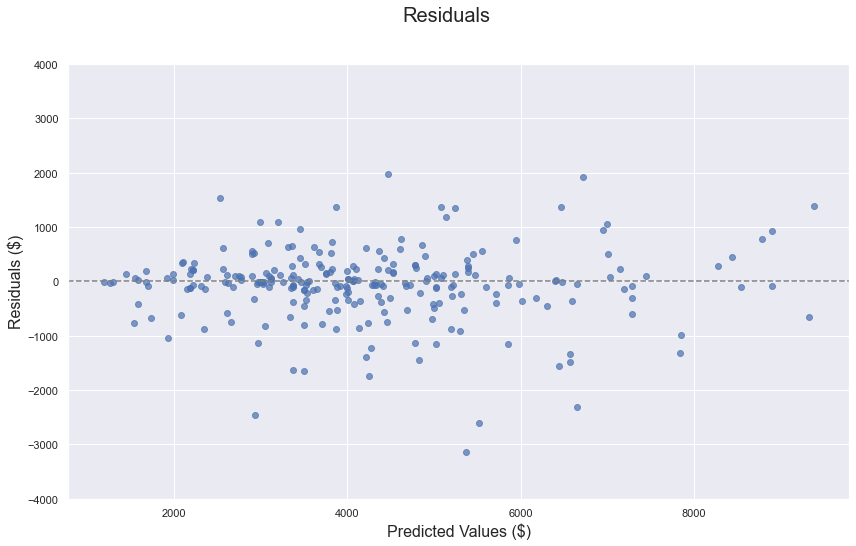

In [26]:
# Plot the residuals with respect to the predicted price

plt.figure(figsize=(14, 8))
plt.scatter((np.exp(xgb.predict(X_test))), (np.exp(xgb.predict(X_test)))-np.exp(y_test), alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Residuals', fontsize=20, fontname='Arial')
plt.ylim(-4000, 4000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial')

## Evaluate the Feature Importances

In [27]:
# Extracting feature importances from the randomForest model
feature_importances = ({'Name':[],
                        'Score':[]})

for name, score in zip(X_train.columns, xgb.feature_importances_):
  feature_importances['Name'].append(name)
  feature_importances['Score'].append(score)

feature_importances = pd.DataFrame(feature_importances).sort_values(['Score'], ascending = False)

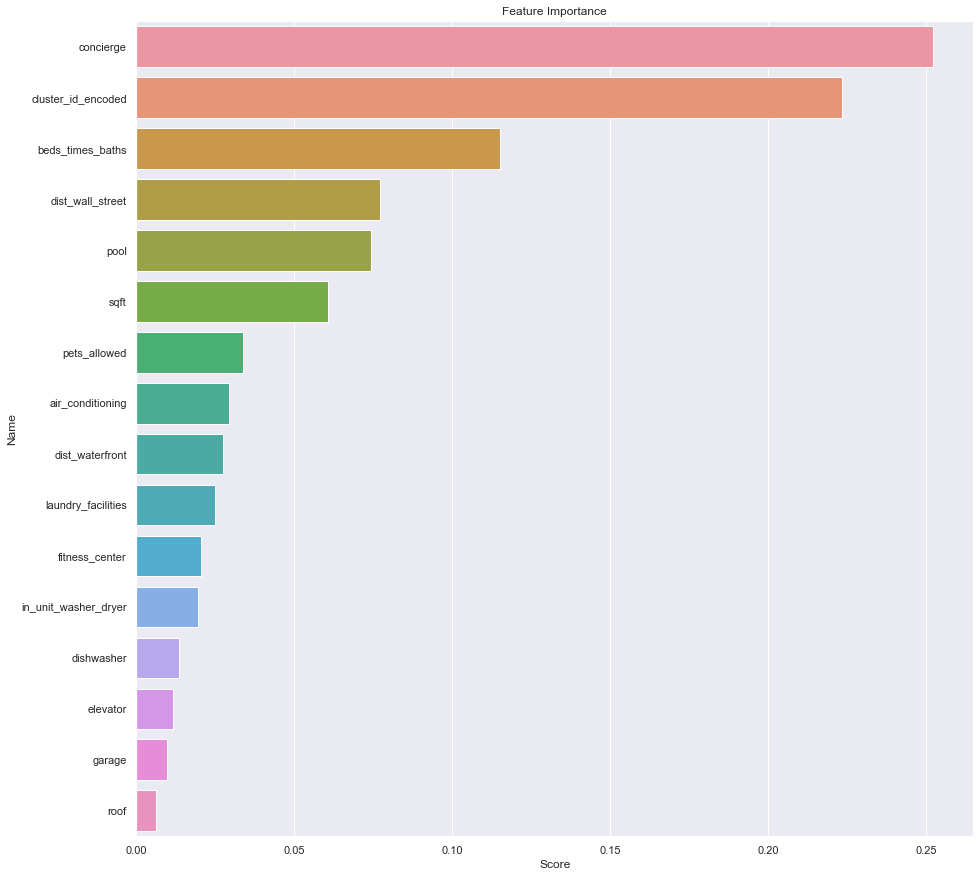

In [28]:
# Plot the feature importances
fig = plt.figure(figsize=(15,15))
sns.barplot(x = 'Score', y = 'Name', data = feature_importances)
plt.title('Feature Importance')
plt.show()

## Hyperparameter Tuning for XGBoost

In [29]:
params = {"n_estimators": np.arange(100,1000,250),
"learning_rate": np.arange(0.1,0.3,0.025),
 "max_depth": np.arange(3,10,1),
 "min_child_weight": np.arange(3,20,2),
 "reg_alpha": np.arange(0,1,0.1)}

In [30]:
regressor=XGBRegressor()

In [31]:
search = RandomizedSearchCV(regressor, param_distributions=params, cv=5)

In [32]:
# search.fit(X_train,y_train)

In [33]:
# best_params=search.best_params_
# best_params

best_params = {'reg_alpha': 0.4,
 'n_estimators': 600,
 'min_child_weight': 15,
 'max_depth': 5,
 'learning_rate': 0.19999999999999998}

In [34]:
xgb=XGBRegressor(n_estimators = best_params['n_estimators'], 
                max_depth = best_params['max_depth'],
                learning_rate = best_params['learning_rate'],
                reg_alpha = best_params['reg_alpha']
                )

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.19999999999999998,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# Training data
pred_train = xgb.predict(X_train)
r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))

# Test data
pred_test = xgb.predict(X_test)
r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))

# Print results
print('R squared training set', round(r2_train,2))
print('R squared test set', round(r2_test,2))
print('RMSE training set', round(mse_train, 2))
print('RMSE test set', round(mse_test, 2))

R squared training set 0.97
R squared test set 0.89
RMSE training set 293.47
RMSE test set 601.25


In [36]:
# Export the model for future use

with open('./models/manhattan_rent_prediction.pickle', 'wb') as handle:
    pkl.dump(xgb, handle)

In [37]:
# Export the clustering for future use

with open('./models/manhattan_cluster_kmeans.pickle', 'wb') as handle:
    pkl.dump(kmeans, handle)

In [38]:
# Export the cluster target encoding for future use

with open('./models/manhattan_encoded_clusters.pickle', 'wb') as handle:
    pkl.dump(encoded_clusters, handle)